# Neural Image Caption Generator
##### I build a Deep Learning model using Keras, for genarating English caption text for any given image

#### Build a vocabulary of the most commonly occurring words in the caption text

In [1]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [2]:
print(type(content))

<class 'dict'>


In [3]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [4]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [5]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [6]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 2644


#### Prepare train and test data

In [7]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/testImages.txt", 'r') as file:
    test_file_data = file.read()

In [8]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [9]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [10]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [11]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

### Transfer Learning

#### Extract features from Image using a ResNet50 Architecture

In [12]:
# import keras.applications.resnet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))
model = ResNet50 (weights = 'imagenet', input_shape = (224, 224, 3))
# resnet50_model = Model (resnet50_model.input, resnet50_model.layers[-2].output)

In [13]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [14]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [15]:
# from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image (img):
    img = load_img(img, target_size=(224, 224))
    img = img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


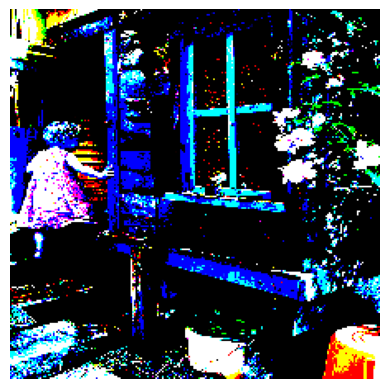

In [16]:
import matplotlib.pyplot as plt

img = preprocess_image("data/Images/1000268201_693b08cb0e.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [17]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [18]:
from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

1/1 [==============================] - 1s 1s/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 87ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 92ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 91ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 87ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 87ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 88ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 90ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 87ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 88ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 89ms/step
Encoding in progress... STEP 1000
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 93ms/step
Encoding in progress... STEP 1100
1/1 [==============================] - 0s 93ms/step
Encoding in progress... STEP 1200
1/1 [==============================] - 0s 95ms/step
Encoding in progress... STEP 1300
1/1 [==============================] - 0s 94ms/step
Encoding in progress... STEP 1400
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 124ms/step
Encoding in progress... STEP 1500
1/1 [==============================] - 0s 99ms/step
Encoding in progress... STEP 1600
1/1 [==============================] - 0s 101ms/step
Encoding in progress... STEP 1700
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 92ms/step
Encoding in progress... STEP 1800
1/1 [==============================] - 0s 96ms/step
Encoding in progress... STEP 1900
1/1 [==============================] - 0s 119ms/step
Encoding in progress... STEP 2000
1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 136ms/step
Encoding in progress... STEP 2100
1/1 [==============================] - 0s 116ms/step
Encoding in progress... STEP 2200
1/1 [==============================] - 0s 100ms/step
Encoding in progress... STEP 2300
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 99ms/step
Encoding in progress... STEP 2400
1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 100ms/step
Encoding in progress... STEP 2500
1/1 [==============================] - 0s 105ms/step
Encoding in progress... STEP 2600
1/1 [==============================] - 0s 104ms/step
Encoding in progress... STEP 2700
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 108ms/step
Encoding in progress... STEP 2800
1/1 [==============================] - 0s 109ms/step
Encoding in progress... STEP 2900
1/1 [==============================] - 0s 113ms/step
Encoding in progress... STEP 3000
1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 117ms/step
Encoding in progress... STEP 3100
1/1 [==============================] - 0s 118ms/step
Encoding in progress... STEP 3200
1/1 [==============================] - 0s 128ms/step
Encoding in progress... STEP 3300
1/1 [==============================] - 0s 116ms/step
Encoding in progress... STEP 3400
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 120ms/step
Encoding in progress... STEP 3500
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 135ms/step
Encoding in progress... STEP 3600
1/1 [==============================] - 0s 127ms/step
Encoding in progress... STEP 3700
1/1 [==============================] - 0s 129ms/step
Encoding in progress... STEP 3800
1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 136ms/step
Encoding in progress... STEP 3900
1/1 [==============================] - 0s 132ms/step
Encoding in progress... STEP 4000
1/1 [==============================] - 0s 134ms/step
Encoding in progress... STEP 4100
1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 134ms/step
Encoding in progress... STEP 4200
1/1 [==============================] - 0s 134ms/step
Encoding in progress... STEP 4300
1/1 [==============================] - 0s 141ms/step
Encoding in progress... STEP 4400
1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 140ms/step
Encoding in progress... STEP 4500
1/1 [==============================] - 0s 143ms/step
Encoding in progress... STEP 4600
1/1 [==============================] - 0s 141ms/step
Encoding in progress... STEP 4700
1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 141ms/step
Encoding in progress... STEP 4800
1/1 [==============================] - 0s 141ms/step
Encoding in progress... STEP 4900
1/1 [==============================] - 0s 145ms/step
Encoding in progress... STEP 5000
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 146ms/step
Encoding in progress... STEP 5100
1/1 [==============================] - 0s 148ms/step
Encoding in progress... STEP 5200
1/1 [==============================] - 0s 150ms/step
Encoding in progress... STEP 5300
1/1 [==============================] - 0s 154ms/step


Encoding in progress... STEP 5400
1/1 [==============================] - 0s 154ms/step
Encoding in progress... STEP 5500
1/1 [==============================] - 0s 158ms/step
Encoding in progress... STEP 5600
1/1 [==============================] - 0s 161ms/step
Encoding in progress... STEP 5700
1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 162ms/step
Encoding in progress... STEP 5800
1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 167ms/step
Encoding in progress... STEP 5900
1/1 [==============================] - 0s 160ms/step
Total time taken: 937.3266878128052 sec


In [19]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [20]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 [==============================] - 0s 167ms/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 162ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 170ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 172ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 174ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 173ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 174ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 182ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 184ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 177ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 172ms/step
Total time taken: 212.20939683914185 s


In [21]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

#### Pre-process the Captions

In [22]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [23]:
print(len(index_to_word))

2644


In [24]:
print(index_to_word[5])
print(word_to_index['is'])

is
5


In [25]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

In [26]:
print(VOCAB_SIZE)

2647


In [27]:
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [28]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [29]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [30]:
print(max_len)

38


In [31]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
# It is a text file that contains word vectors for a vocabulary of
file = open("glove.6B.50d.txt",encoding='utf8')

In [32]:
# Create a mapping from word to embedding
word_to_embedding = {}

for line in file:
    values = line.split()

    word = values[0]
    embedding = np.array (values[1:], dtype='float')
    word_to_embedding[word] = embedding

file.close()

In [33]:
word_to_embedding["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [34]:
EMBEDDING_DIM = 50

def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding = word_to_embedding.get(word)

        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix



In [35]:
index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)

(2647, 50)


### Define Model Architecture
##### Build a Neural Network using Keras Functional API

In [36]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [37]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 essentially captures the entire sentence that has been generated till now

In [38]:
from tensorflow.keras.layers import add
# from keras.layers.merge import add

# Decode the inputs

# So effectively, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 50)       132350      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [40]:
# Preinitialise Embedding layer
model.layers[2].set_weights([index_to_embedding])
model.layers[2].trainable = False

In [41]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

#### Create a Data Loader

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0     

### Train Model

In [43]:
epochs = 20
batch_size = 3
steps = len(train_content)//batch_size 

In [44]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

C:\Users\vinay\AppData\Local\Temp\ipykernel_9632\3895641940.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, steps_per_epoch=steps)


2000/2000 [==============================] - 640s 320ms/step - loss: 2.2584
